In [1]:
# -*- coding: utf-8 -*-

import os
import cv2
import csv
import math
import random
import numpy as np
import pandas as pd
import argparse
import pickle

import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
import torch.utils.data as data
import torch.nn.functional as F


from utils import *
from resnet import *
from loss import ACLoss

import pickle
from torch.autograd import Variable



class Model(nn.Module):
    def __init__(self, args, pretrained=True, num_classes=7):
        super(Model, self).__init__()
        resnet50 = ResNet(Bottleneck, [3, 4, 6, 3])
        with open(args.resnet50_path, 'rb') as f:
            obj = f.read()
        weights = {key: torch.from_numpy(arr) for key, arr in pickle.loads(obj, encoding='latin1').items()}
        resnet50.load_state_dict(weights)
        
        self.features = nn.Sequential(*list(resnet50.children())[:-2])  
        self.features2 = nn.Sequential(*list(resnet50.children())[-2:-1])  
        self.fc = nn.Linear(2048, 6)  
        
        self.parm={}
        for name,parameters in self.fc.named_parameters():
            print(name,':',parameters.size())
            self.parm[name]=parameters
        
    def forward(self, x, return_feat=False):        
        x = self.features(x)
        #### 1, 2048, 7, 7
        feature = self.features2(x)
        #### 1, 2048, 1, 1
        
        feature = feature.view(feature.size(0), -1)

        output = self.fc(feature)
        fc_weights = self.parm['weight'].cuda()
#         params = list(self.parameters())
#         fc_weights = params[-2].data

        fc_weights = fc_weights.view(1, 6, 2048, 1, 1)
        fc_weights = Variable(fc_weights, requires_grad = False)


        feat = x.unsqueeze(1) # N * 1 * C * H * W
        hm = feat * fc_weights
        hm = hm.sum(2) # N * self.num_labels * H * W
        if return_feat:
            return x
        else:

            return output, hm
        
parser = argparse.ArgumentParser()
parser.add_argument('--raf_path', type=str, default='../data/raf-basic', help='raf_dataset_path')
parser.add_argument('--resnet50_path', type=str, default='./checkpoint/resnet50_ft_weight.pkl', help='pretrained_backbone_path')
parser.add_argument('--label_path', type=str, default='open_noise.txt', help='label_path')
parser.add_argument('--workers', type=int, default=4, help='number of workers')
parser.add_argument('--batch_size', type=int, default=128, help='batch_size')
parser.add_argument('--w', type=int, default=7, help='width of the attention map')
parser.add_argument('--h', type=int, default=7, help='height of the attention map')
parser.add_argument('--gpu', type=int, default=0, help='the number of the device')
parser.add_argument('--lam', type=float, default=6, help='kl_lambda')
parser.add_argument('--epochs', type=int, default=30, help='number of epochs')
args = parser.parse_args(args=[])

import os
import cv2
import torch.utils.data as data
import pandas as pd
import random
from torchvision import transforms
from utils import *
from loss import ACLoss




class RafDataset(data.Dataset):
    def __init__(self, args, phase, basic_aug=True, transform=None):
        self.raf_path = args.raf_path
        self.phase = phase
        self.basic_aug = basic_aug
        self.transform = transform
        ### pseudo labels for open-set detection model training

        dataset = pd.read_csv('predicted_labels_open0.txt', sep=' ', header=None)
        
        name_c = 0
        label_c = 1
            
        self.label = dataset.iloc[:, label_c].values
        self.file_paths = dataset.iloc[:, name_c].values
        self.aug_func = [flip_image, add_g]

        self.clean = True ################ very important, need to set to true to first erase and then flip, otherwise, EAC won't work for open-set detection
        
        


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.label[idx]
        image = cv2.imread(self.file_paths[idx])
            
        image = image[:, :, ::-1]
        
        
        if not self.clean:    
            image1 = image
            image1 = self.aug_func[0](image)
            image1 = self.transform(image1)

        if self.phase == 'train':
            if self.basic_aug and random.uniform(0, 1) > 0.5:
                image = self.aug_func[1](image)

        if self.transform is not None:
            image = self.transform(image)
        
        if self.clean:
            image1 = transforms.RandomHorizontalFlip(p=1)(image)

        return image, label, idx, image1
    
    
    
def train(args, model, train_loader, optimizer, scheduler, device):
    running_loss = 0.0
    iter_cnt = 0
    correct_sum = 0
    
    model.to(device)
    model.train()

    total_loss = []
    for batch_i, (imgs1, labels, indexes, imgs2) in enumerate(train_loader):
        imgs1 = imgs1.to(device)
        imgs2 = imgs2.to(device)
        labels = labels.to(device)


        criterion = nn.CrossEntropyLoss(reduction='none')



        output, hm1 = model(imgs1)
        output_flip, hm2 = model(imgs2)
        
        grid_l = generate_flip_grid(args.w, args.h, device)
        

        loss1 = nn.CrossEntropyLoss()(output, labels)
        flip_loss_l = ACLoss(hm1, hm2, grid_l, output)


        loss = loss1 + args.lam * flip_loss_l


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        iter_cnt += 1
        _, predicts = torch.max(output, 1)
        correct_num = torch.eq(predicts, labels).sum()
        correct_sum += correct_num
        running_loss += loss

    scheduler.step()
    running_loss = running_loss / iter_cnt
    acc = correct_sum.float() / float(train_loader.dataset.__len__())
    return acc, running_loss


    
def test(model, test_loader, device):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        iter_cnt = 0
        correct_sum = 0
        data_num = 0


        for batch_i, (imgs1, labels, indexes, imgs2) in enumerate(test_loader):
            imgs1 = imgs1.to(device)
            labels = labels.to(device)


            outputs, _ = model(imgs1)


            loss = nn.CrossEntropyLoss()(outputs, labels)

            iter_cnt += 1
            _, predicts = torch.max(outputs, 1)

            correct_num = torch.eq(predicts, labels).sum()
            correct_sum += correct_num

            running_loss += loss
            data_num += outputs.size(0)

        running_loss = running_loss / iter_cnt
        test_acc = correct_sum.float() / float(data_num)
    return test_acc, running_loss
        
        

setup_seed(0)

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(scale=(0.02, 0.25)) ])

eval_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])



train_dataset = RafDataset(args, phase='train', transform=train_transforms)
test_dataset = RafDataset(args, phase='test', transform=eval_transforms)



train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=True,
                                           num_workers=args.workers,
                                           pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)




model = Model(args)

device = torch.device('cuda:{}'.format(args.gpu))
model.to(device)
model = torch.nn.DataParallel(model)

optimizer = torch.optim.Adam(model.parameters() , lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)





for i in range(1, args.epochs + 1):
    train_acc, train_loss = train(args, model, train_loader, optimizer, scheduler, device)
    torch.save({'model_state_dict': model.module.state_dict()}, "model_for_open_detection.pth")
    print('saved', 'epoch: ', i, 'acc: ', train_acc)

weight : torch.Size([6, 2048])
bias : torch.Size([6])


## EAC test

In [2]:
import os
import cv2
import csv
import math
import random
import numpy as np
import pandas as pd
import argparse
import pickle

import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
import torch.utils.data as data
import torch.nn.functional as F


from utils import *
from resnet import *


import pickle
from torch.autograd import Variable



class Model(nn.Module):
    def __init__(self, args, pretrained=True, num_classes=7):
        super(Model, self).__init__()
        resnet50 = ResNet(Bottleneck, [3, 4, 6, 3])
        with open(args.resnet50_path, 'rb') as f:
            obj = f.read()
        weights = {key: torch.from_numpy(arr) for key, arr in pickle.loads(obj, encoding='latin1').items()}
        resnet50.load_state_dict(weights)
        
        self.features = nn.Sequential(*list(resnet50.children())[:-2])  
        self.features2 = nn.Sequential(*list(resnet50.children())[-2:-1])  
        self.fc = nn.Linear(2048, 6)  
        
        self.parm={}
        for name,parameters in self.fc.named_parameters():
            print(name,':',parameters.size())
            self.parm[name]=parameters
        
    def forward(self, x, return_feat=False):        
        x = self.features(x)
        #### 1, 2048, 7, 7
        feature = self.features2(x)
        #### 1, 2048, 1, 1
        
        feature = feature.view(feature.size(0), -1)

        output = self.fc(feature)
        fc_weights = self.parm['weight'].cuda()
#         params = list(self.parameters())
#         fc_weights = params[-2].data

        fc_weights = fc_weights.view(1, 6, 2048, 1, 1)
        fc_weights = Variable(fc_weights, requires_grad = False)


        feat = x.unsqueeze(1) # N * 1 * C * H * W
        hm = feat * fc_weights
        hm = hm.sum(2) # N * self.num_labels * H * W
        if return_feat:
            return x
        else:

            return output, hm
        
parser = argparse.ArgumentParser()
parser.add_argument('--raf_path', type=str, default='../data/raf-basic', help='raf_dataset_path')
parser.add_argument('--resnet50_path', type=str, default='./checkpoint/resnet50_ft_weight.pkl', help='pretrained_backbone_path')
parser.add_argument('--label_path', type=str, default='open_noise.txt', help='label_path')
parser.add_argument('--workers', type=int, default=4, help='number of workers')
parser.add_argument('--batch_size', type=int, default=128, help='batch_size')
parser.add_argument('--w', type=int, default=7, help='width of the attention map')
parser.add_argument('--h', type=int, default=7, help='height of the attention map')
parser.add_argument('--gpu', type=int, default=0, help='the number of the device')
parser.add_argument('--lam', type=float, default=8, help='kl_lambda')
parser.add_argument('--epochs', type=int, default=60, help='number of epochs')
args = parser.parse_args(args=[])

import os
import cv2
import torch.utils.data as data
import pandas as pd
import random
from torchvision import transforms
from utils import *

class RafDataset(data.Dataset):
    def __init__(self, args, phase, basic_aug=True, transform=None):
        self.raf_path = args.raf_path
        self.phase = phase
        self.basic_aug = basic_aug
        self.transform = transform
        dataset = pd.read_csv('predicted_labels_open0.txt', sep=' ', header=None)
        
        name_c = 0
        label_c = 1
            
        self.label = dataset.iloc[:, label_c].values
        self.file_paths = dataset.iloc[:, name_c].values
        self.aug_func = [flip_image, add_g]

        self.clean = (args.label_path == 'list_patition_label.txt')


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.label[idx]
        image = cv2.imread(self.file_paths[idx])
            
        image = image[:, :, ::-1]
        
        
        if not self.clean:    
            image1 = image
            image1 = self.aug_func[0](image)
            image1 = self.transform(image1)

        if self.phase == 'train':
            if self.basic_aug and random.uniform(0, 1) > 0.5:
                image = self.aug_func[1](image)

        if self.transform is not None:
            image = self.transform(image)
        
        if self.clean:
            image1 = transforms.RandomHorizontalFlip(p=1)(image)

        return image, label, idx, image1
    

    
def test(model, test_loader, device):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        iter_cnt = 0
        correct_sum = 0
        data_num = 0


        for batch_i, (imgs1, labels, indexes, imgs2) in enumerate(test_loader):
            imgs1 = imgs1.to(device)
            labels = labels.to(device)


            outputs, _ = model(imgs1)


            loss = nn.CrossEntropyLoss()(outputs, labels)

            iter_cnt += 1
            _, predicts = torch.max(outputs, 1)

            correct_num = torch.eq(predicts, labels).sum()
            correct_sum += correct_num

            running_loss += loss
            data_num += outputs.size(0)

        running_loss = running_loss / iter_cnt
        test_acc = correct_sum.float() / float(data_num)
    return test_acc, running_loss
        
        
        

setup_seed(0)

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(scale=(0.02, 0.25)) ])

eval_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])



train_dataset = RafDataset(args, phase='train', transform=train_transforms)


train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=False,
                                           num_workers=args.workers,
                                           pin_memory=True)




model = Model(args)
device = torch.device('cuda:{}'.format(args.gpu))
model.to(device)
model = torch.nn.DataParallel(model)
model.module.load_state_dict(torch.load('model_for_open_detection.pth')['model_state_dict'])



# def train(args, model, train_loader, optimizer, scheduler, device):
running_loss = 0.0
iter_cnt = 0
correct_sum = 0
with torch.no_grad():
    model.eval()

    total_loss = []
    for batch_i, (imgs1, labels, indexes, imgs2) in enumerate(train_loader):
        imgs1 = imgs1.to(device)
        imgs2 = imgs2.to(device)
        labels = labels.to(device)

        criterion = nn.CrossEntropyLoss(reduction='none')


        output, hm1 = model(imgs1)
        output_flip, hm2 = model(imgs2)
        grid_l = generate_flip_grid(args.w, args.h, device)
        loss1 = nn.CrossEntropyLoss(reduction='none')(output, labels)
        
        total_loss.append(loss1.detach().cpu().numpy())

print('the end')

weight : torch.Size([6, 2048])
bias : torch.Size([6])


/home/pc/anaconda3/envs/visgpt/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


the end


## find index

In [3]:
open_idx = []
file = open('predicted_labels_open0_openset_index.txt',"r")
lines = file.readlines()
for line in lines:
    open_idx.append(int(line.split()[0]))

In [4]:
new_total = np.concatenate(total_loss)

In [5]:
ind_idx = []
for i in range(len(new_total)):
    if i not in open_idx:
        ind_idx.append(i)

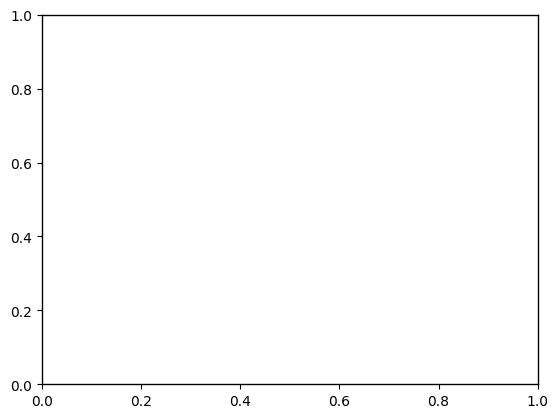

In [6]:
#set style

import matplotlib.pyplot as plt
import seaborn as sns

ax = plt.gca()
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)

sns.set_style('darkgrid', {'axes.facecolor': '0.96', 'axes.linewidth': 20, 'axes.edgecolor': '0.15'})

from scipy import stats

    
plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]


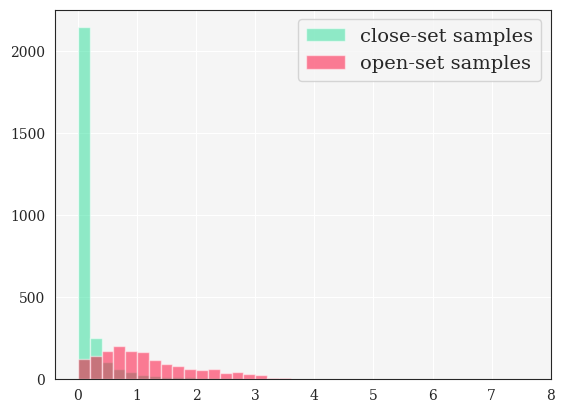

In [7]:
import matplotlib.pyplot as plt
plt.hist(new_total[np.array(ind_idx)], bins=np.arange(0, 8, 0.2), color='#28DF99', label='close-set samples', alpha=0.5)
plt.hist(new_total[np.array(open_idx)], bins=np.arange(0, 8, 0.2), color='#FF0032', label = 'open-set samples', alpha=0.5)
plt.xlim(xmax=8)
plt.legend(prop={'size':14})
plt.savefig('cons_loss.png',dpi=500, bbox_inches='tight')
plt.show()

In [9]:
from tqdm import trange
import numpy as np

from ood_metrics import fpr_at_95_tpr
from ood_metrics import auroc
from tqdm import trange

import matplotlib.pyplot as plt


X1 = -new_total[np.array(ind_idx)]
Y1 = -new_total[np.array(open_idx)]

labels = np.concatenate((np.ones(len(X1)), np.zeros(len(Y1))))
scores = np.concatenate((X1, Y1))
fprBase = fpr_at_95_tpr(scores, labels)
aurocBase = auroc(scores, labels)
print(fprBase)
print(aurocBase)

0.4842495367510809
0.9225479603855367
